In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from tqdm import tqdm
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.0+cu117


In [18]:
from dataset import TerrainDataset
from pointnet import PointNet

dataset = TerrainDataset(root='/home/atas/unity_data/data',train=True)


Processing...


Processing...


Raw data list size with augmented ops:  182
Choosed to augment with noise rate of:  0.5
Choosed to augment with downsample rate of:  0.5
Total data list size with augmented ops:  364
Added  182  augmented samples
Raw data list size with augmented ops:  20
Choosed to augment with noise rate of:  0.5
Choosed to augment with downsample rate of:  0.5
Total data list size with augmented ops:  40
Added  20  augmented samples


Done!


In [19]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

from torch_geometric.loader import DataLoader

train_dataset =  TerrainDataset(root='/home/atas/unity_data/data', train=True )
test_dataset = TerrainDataset(root='/home/atas/unity_data/data', train=False)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()  # Mean Squared Error Loss Function
criterion = torch.nn.L1Loss()  # Mean Absolute Error (L1 Loss Function)

def train(model, optimizer, loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        optimizer.zero_grad()                   # Clear gradients.
        # reshape to have 1 at the end
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        logits = model(data.pos, data.batch)                # Forward pass.
        loss = criterion(logits, data.y)        # Loss computation.
        loss.backward()                         # Backward pass.
        optimizer.step()                        # Update model parameters.
        total_loss += loss.item()

    return total_loss


@torch.no_grad()
def test(model, loader):
    model.eval()

    error = 0.0
    for data in loader:
        data.pos = data.pos.reshape((data.pos.shape[0], data.pos.shape[1], 1))
        pred = model(data.pos, data.batch)
        error += torch.pow((pred - data.y), 2).sum().item()
    
    # convert error to percentage accuracy
    return error

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 119.2793, MSE: 3.1753
Epoch: 02, Loss: 79.4407, MSE: 2.3152
Epoch: 03, Loss: 62.6366, MSE: 2.3193
Epoch: 04, Loss: 52.6673, MSE: 3.7254
Epoch: 05, Loss: 46.1030, MSE: 2.7664
Epoch: 06, Loss: 45.7522, MSE: 1.8930
Epoch: 07, Loss: 40.4748, MSE: 1.8991
Epoch: 08, Loss: 36.9463, MSE: 2.7026
Epoch: 09, Loss: 37.4073, MSE: 1.9984
Epoch: 10, Loss: 32.5997, MSE: 2.2975
Epoch: 11, Loss: 33.9482, MSE: 2.0296
Epoch: 12, Loss: 29.7612, MSE: 2.0368
Epoch: 13, Loss: 28.9364, MSE: 2.0569
Epoch: 14, Loss: 35.7713, MSE: 2.2294
Epoch: 15, Loss: 33.1585, MSE: 2.0383
Epoch: 16, Loss: 30.6011, MSE: 1.9580
Epoch: 17, Loss: 31.8097, MSE: 3.1805
Epoch: 18, Loss: 28.3999, MSE: 1.8613
Epoch: 19, Loss: 31.0541, MSE: 2.0573
Epoch: 20, Loss: 29.5956, MSE: 2.1338
Epoch: 21, Loss: 30.1695, MSE: 2.4750
Epoch: 22, Loss: 27.6187, MSE: 2.1947
Epoch: 23, Loss: 27.6552, MSE: 2.0153
Epoch: 24, Loss: 24.2943, MSE: 1.9824
Epoch: 25, Loss: 24.0726, MSE: 2.3382
Epoch: 26, Loss: 30.0823, MSE: 2.1012
Epoch: 27, 

Text(0.5, 0, 'epochs')

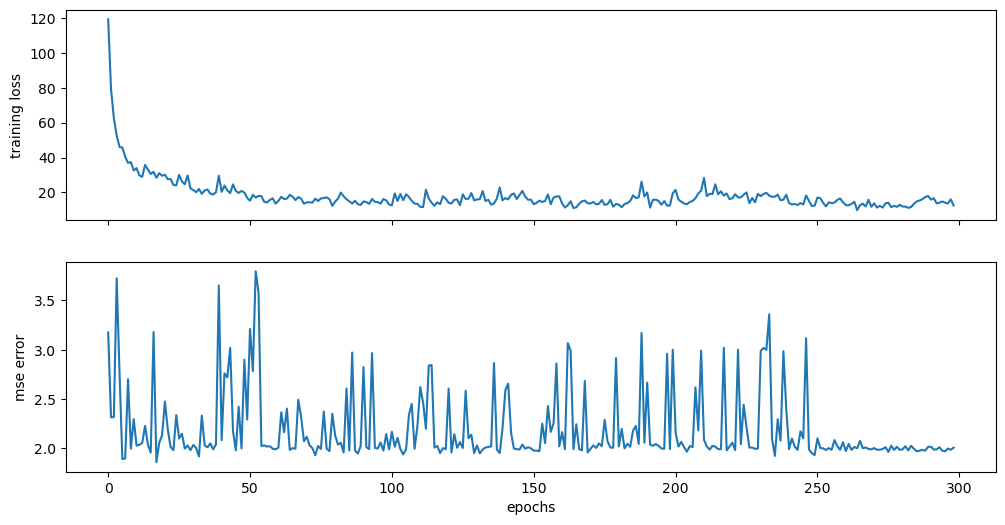

In [20]:
train_loss=[]
test_mse=[]

# Save every 10th epoch model.
for epoch in range(1, 300):
    loss = train(model, optimizer, train_loader)
    mse = test(model, test_loader)
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'epoch_{epoch}.pt')
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, MSE: {mse:.4f}')
    train_loss.append(loss)
    test_mse.append(mse)
    
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)
ax1.plot(train_loss)
ax1.set_ylabel("training loss")
ax2.plot(test_mse)
ax2.set_ylabel("mse error")
ax2.set_xlabel("epochs")    

In [22]:
visual_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model
net = PointNet()
net.load_state_dict(torch.load('epoch_290.pt'))
net.eval()

error = 0.0
for data in visual_test_loader:
 
    inputs, labels = data.pos, data.y
    inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], 1))
    outputs = net(inputs, data.batch)
    
    error += torch.pow((outputs - data.y), 2).sum().item()
    outputs = outputs.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    print(data.batch)
    #print("GT " + str(labels), "Pred " + str(outputs))

error = error / len(visual_test_loader)
print("MSE: " + str(error))    


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0,